# Music Affinity Across Boundaries

Spotify, the leading online music streaming platform with over 381 Million users across 184 markets, maintains lists of the top 50 tracks for over [insert # of countries] countries. The goal of this analysis is to determine if there are similarities or disimilarities between popular music accross geographic and social boundaries.

Our analysis will focus on the audio features of songs contained in these top 50 lists. These audio features are sourced either directly from Spotify or are obtained from our own music information retreval process on the audio previews Spotify provides for most songs.

### Insert overview of data collection and transformation process

yatta yatta yatta yatta

In [23]:
#Import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Data Exploration

In [2]:
#Bring in data
df = pd.read_csv('lookups/all_track_audio_features.csv')

df.dropna(axis=0, inplace=True)

df_tracks = df[['track_id','duration_ms','update_dttm',
       'name', 'artist', 'album_img', 'preview_url', 'popularity','basic_kmeans_cluster','adv_kmeans_cluster']]

features = ['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo_x', 'time_signature', 'chroma', 'chroma_cens', 'mff',
       'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast',
       'spectral_flatness', 'Spectral_Rolloff', 'poly_features', 'tonnetz',
       'ZCR', 'onset_strength', 'pitch', 'magnitude', 'tempo']


One of the first issues we need to overcome is the fact that songs can be shared across playlists/countries. As seen below, certain songs and artists are popular across the world.

In [3]:
df_pd = pd.read_csv('playlist_data/playlist_data.csv')

df_pd['unique_id'] = df_pd.country + '-' + df_pd.track_id

df_pd = df_pd.drop_duplicates(subset=['unique_id'])

df_pd = df_pd[['country', 'market', 'track_artist','track_name','track_id']]
df_pd = df_pd[df_pd.country != 'global']

df_cross = df_pd[['market','track_id']].groupby(by='track_id').count()
df_cross.reset_index(inplace=True)
df_cross.rename(columns={'market':'list_count'},inplace=True)

df_temp = df.merge(df_cross, on='track_id', how='left')



df_viz = df_temp.sort_values('list_count', ascending=False)
df_viz = df_viz[['name','artist','album_img','list_count']]
df_viz['song'] = df_viz.name + ' - ' + df_viz.artist
df_viz.drop_duplicates(subset=['song'], keep='first', inplace=True)

df_viz.album_img[0]
                          

'https://i.scdn.co/image/ab67616d0000b27350dba34377a595e35f81b0e4'

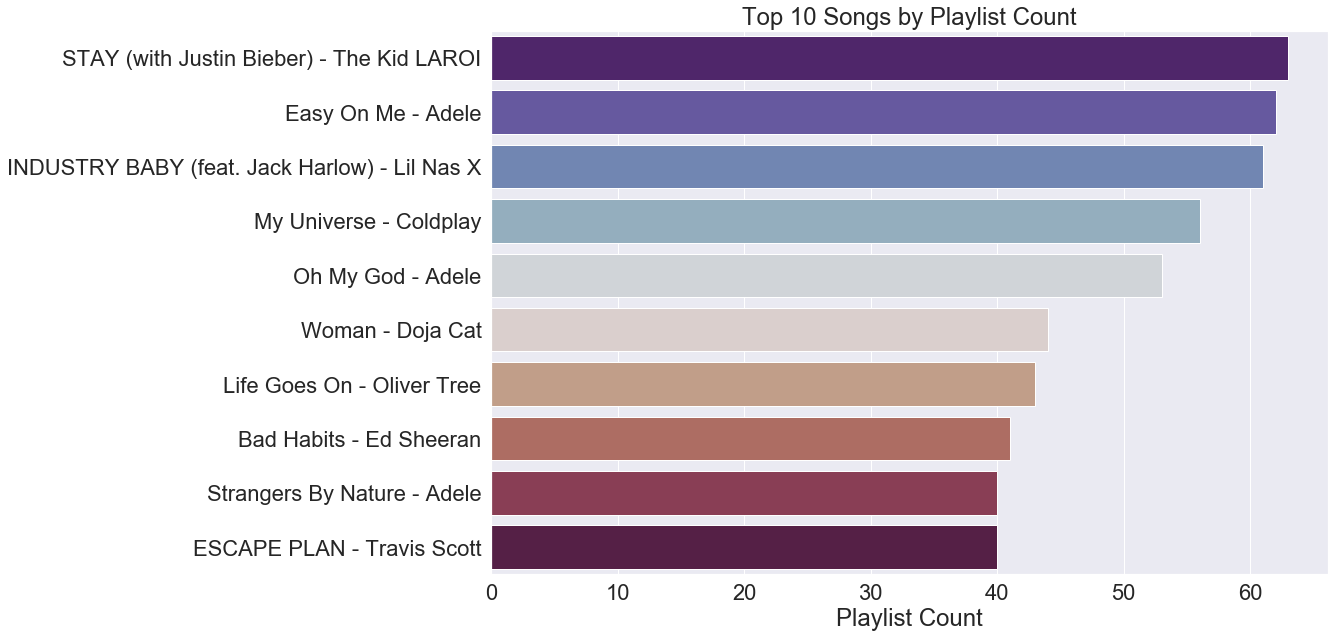

In [20]:
sb.set(font_scale=2)
fig, ax = plt.subplots(figsize=(15,10))
ax = sb.barplot(x='list_count', y='song', data=df_viz.head(10), palette='twilight_shifted')
ax.set_xlabel('Playlist Count')
ax.set_ylabel(None)
ax.set_title('Top 10 Songs by Playlist Count')

plt.show()

## work on making this visual look better. Perhaps include image art somewhere. 
## Also show histogram to the right to show distribution

This may lend creedence to the assertion that music tastes are similar across boundaries. However, we want to develop a complete picture of a country's musical taste. In order to do this, we need to capture the average feature for a playlist across all songs it contains.

In [21]:
c_feat = {}

for ctry in df_pd.country.tolist():
    tracks = df_pd[df_pd['country']==ctry].track_id.tolist()
    df_temp = df[df.track_id.isin(tracks)]
    c_feat[ctry] = df_temp[features].mean(axis=0).tolist()
    
df_ctry_feat = pd.DataFrame.from_dict(c_feat, orient='index', columns=features)

In [24]:
df_ctry_feat.columns


Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_x',
       'time_signature', 'chroma', 'chroma_cens', 'mff', 'spectral_centroid',
       'spectral_bandwidth', 'spectral_contrast', 'spectral_flatness',
       'Spectral_Rolloff', 'poly_features', 'tonnetz', 'ZCR', 'onset_strength',
       'pitch', 'magnitude', 'tempo'],
      dtype='object')

In [37]:
#create kmeans clusters
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
scaler = StandardScaler()
X = df_ctry_feat.drop(columns=['tempo_x'])
X = scaler.fit_transform(X)
inert = []
sil = []
axis = []

for i, n in enumerate(range(2,21)):
    n_clusters = n
    kmean = KMeans(n_clusters=n_clusters, init='k-means++')
    cluster_labels = kmean.fit_predict(X)
    inert.append(kmean.inertia_)
    axis.append(n)
    sil.append(silhouette_score(X,cluster_labels))
    


# centers = kmean.cluster_centers_
# labels = kmean.labels_

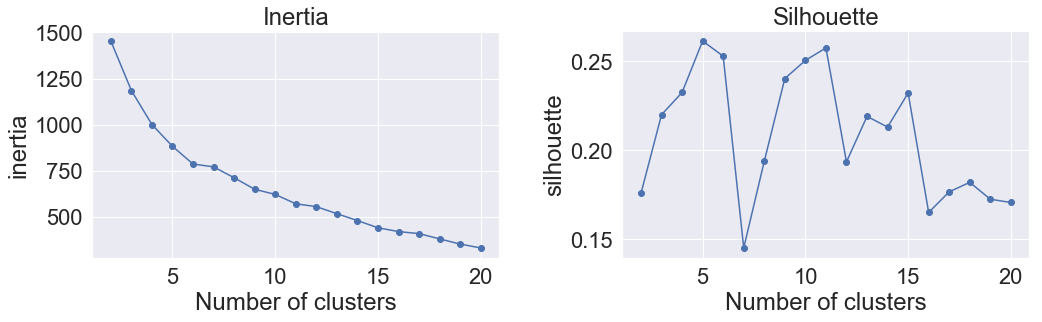

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(axis, inert, marker='o')
ax1.set(xlabel='Number of clusters', ylabel='inertia',title='Inertia')

ax2.plot(axis, sil, marker='o')
ax2.set(xlabel='Number of clusters', ylabel='silhouette',title='Silhouette')


plt.tight_layout()
plt.show()

In [47]:
#Apply Kmeans using optimal number of clusters
kmean = KMeans(n_clusters=6, init='k-means++')
cluster_labels = kmean.fit_predict(X)
centers = kmean.cluster_centers_



In [51]:
#Apply PCA and build new df for viz
num_components=3
pca = PCA(n_components=num_components)
p_comps = pca.fit_transform(X)
final=None
cols = ['PC{}'.format(i+1) for i in range(num_components) ]
final = pd.DataFrame(p_comps, columns=cols)
final['country'] = df_ctry_feat.index
final['cluster'] = cluster_labels
print(pca.components_)


[[-1.89206245e-01 -2.65197161e-01  6.88514081e-02 -7.27814874e-02
   1.31428454e-01 -2.27732888e-01  3.19502569e-01 -1.03217905e-01
  -2.92359473e-02 -1.34665543e-01 -1.47908907e-01 -2.82582216e-01
  -2.01741644e-01 -1.07903376e-01 -3.20445725e-01 -2.97645123e-01
   2.74859542e-01 -2.89348961e-01 -3.20466095e-01 -4.88096494e-02
   3.64107018e-02 -1.64469447e-01 -1.48487406e-01 -9.26376208e-02
   1.19358126e-01  4.24554620e-03]
 [ 3.35409328e-01  1.60748746e-01 -1.57346504e-01  1.96919697e-01
  -2.56132058e-01  1.11334792e-01 -5.77835963e-02 -4.30814143e-02
  -3.76909966e-03  2.10064979e-01 -1.27359462e-01 -2.22398112e-02
   2.26223208e-01 -2.47119552e-01 -1.61326176e-01 -5.82782386e-02
   2.12099260e-01 -2.33126404e-01 -9.66081384e-02 -4.81218622e-02
  -1.09800255e-01 -3.22495935e-01  3.73562770e-01 -2.23255775e-01
  -1.24281558e-01 -2.83771553e-01]
 [-5.27185973e-02  2.48892148e-01  1.17139342e-02  3.98017824e-01
   1.57836775e-01 -2.02401970e-01 -3.66392367e-02 -1.86442498e-01
   1.6

In [68]:
# from mpl_toolkits import mplot3d

# z = final.PC1
# x = final.PC2
# y = final.PC3

# fig = plt.figure(figsize = (10,10))
# ax = plt.axes(projection='3d')

# ax.scatter3D(x, y, z)

# plt.show()

import plotly.express as px

fig = px.scatter_3d(final, x='PC1', y='PC2', z='PC3', color='cluster',
                    hover_data=['country','cluster'], width=1000,
                    height=1000)
fig.update_layout(showlegend=False)
fig.show()

C:\Users\Felip3\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

C:\Users\Felip3\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



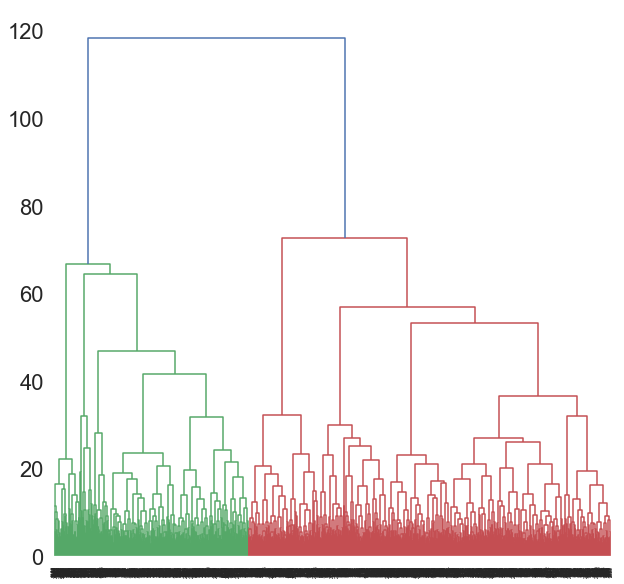

In [74]:




# df.drop(['Unnamed: 0','duration_ms','update_dttm','name',
#          'artist', 'album_img', 'preview_url', 'popularity',
#          'cluster'],
#         axis=1, inplace=True)



# X = df.loc[:, df.columns != 'track_id']
# y = df[['track_id']]
X = scaler.fit_transform(df[features])

S = sch.linkage(X, method='ward')
fig=plt.figure(figsize=(10,10))
sch.dendrogram(S)

plt.show()

In [76]:
def get_clusters(df, num_clusters):
    clusters=num_clusters
    model = AgglomerativeClustering(n_clusters = clusters, affinity='euclidean', linkage='ward')
    model.fit(df)
    return model.labels_


In [77]:
def create_df(df, num_clusters, num_components):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=num_components)
    p_comps = pca.fit_transform(df)
    final=None
    cols = ['PC{}'.format(i+1) for i in range(num_components) ]
    final = pd.DataFrame(p_comps, columns=cols)
    final['cluster'] = get_clusters(df, num_clusters)
    return final

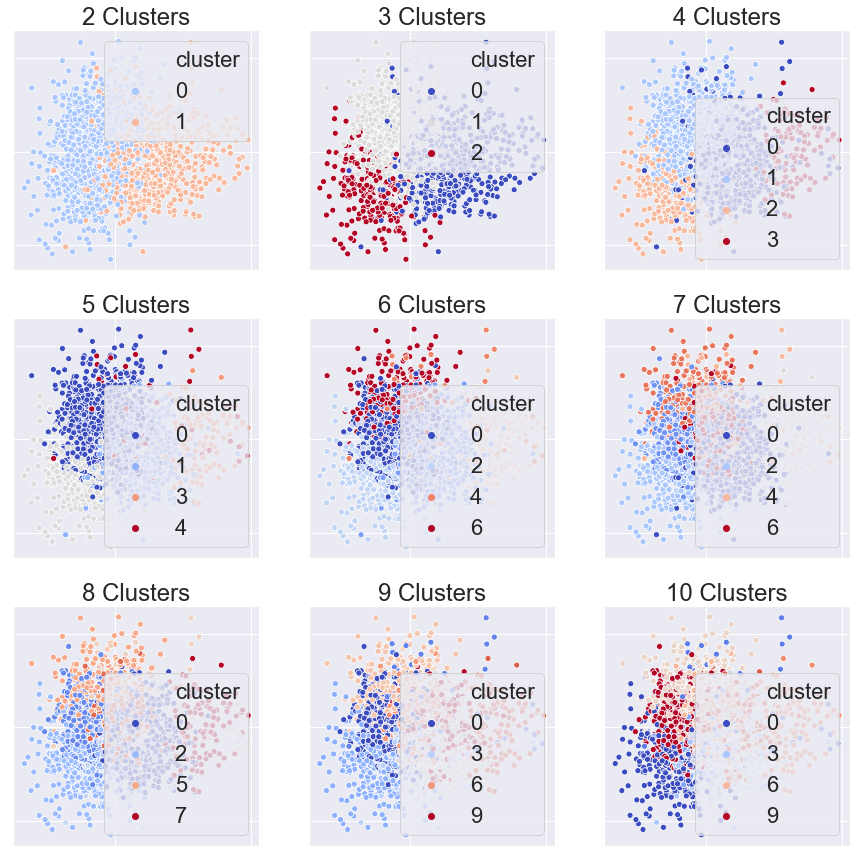

In [78]:
import seaborn as sns
num_clusters = 10
subs = num_clusters-1
cols = 3
# if plots
rows = subs//cols
rows += subs % cols
pos = range (1,subs)

fig, axs = plt.subplots(rows,cols,gridspec_kw={'width_ratios':[1 for i in range(cols)]},figsize=(15,15))

for ax,n in zip(axs.flatten(),range(2,num_clusters+1)):

    df = create_df(X, n, 2)
    sns.scatterplot(data = df, x='PC1', y='PC2', hue='cluster', palette='coolwarm', ax=ax).set(
        xlabel=None,
        ylabel=None,
        xticklabels=[],
        yticklabels=[],
        title='{} Clusters'.format(n)
        )
plt.show()